<h1><span style="color: #6495ED;">Elevating Air Quality Predictions: Unleashing RandomForest for Accurate Air Quality Index Modeling</span></h1>

Prepared by Lipsita Tripathy

Email: lipsitalt@gmail.com

January 2024

## Introduction

- This notebook embarks on an in-depth exploration and modeling journey to predict air quality using the AutoRegressive Integrated Moving Average (ARIMA) and Seasonal AutoRegressive Integrated Moving Average (SARIMA) time series forecasting techniques. 
- The dataset encompasses a rich array of features, including meteorological conditions and pollutant concentrations, forming the basis for accurate air quality predictions. 
- The key steps involve time series decomposition, trend analysis, and employing ARIMA and SARIMA models tailored to capture temporal patterns and seasonality. 
- The focus extends to optimizing model hyperparameters to achieve superior predictive performance. 
- This comprehensive analysis lays the groundwork for understanding the intricate temporal dynamics and enhancing forecasting capabilities for air quality in the Delhi region.

### Importing necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from joblib import Parallel, delayed
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from itertools import product

### Read the required CSV file into a DataFrame

In [2]:
df = pd.read_csv('data/generated/Delhi_AQI_final_df_before_modeling.csv')
df.head()

,Datetime,AQI,PM2.5 (ug/m3),PM10 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),RH (%),...,t_CO (ug/m3),t_Ozone (ug/m3),t_WS (m/s),t_SR (W/mt2),t_Volatility_Last_24hr,t_Volatility_Last_7d,t_Volatility_Last_30d,t_AQI_lag_24hr,t_AQI_lag_48hr,t_AQI_lag_168hr
0,2013-01-01 00:00:00,354.0,290.774583,292.631667,117.224563,75.685556,9.992130,5.052250,13.794630,88.716778,...,1.800430,2.694264,0.314162,3.714195,2.230820,3.405326,4.138828,5.831882,5.961005,6.075346
1,2013-01-01 01:00:00,358.0,275.749821,296.150000,88.122976,66.740556,9.477546,7.665310,9.977963,89.612778,...,2.159328,2.395890,0.330103,3.673794,2.353812,3.397713,4.138876,5.823046,5.966147,6.073045
2,2013-01-01 02:00:00,362.0,271.463472,309.030000,61.464690,57.030556,9.207963,10.777421,7.316574,91.010556,...,2.466184,2.118250,0.329304,3.455326,2.475083,3.389909,4.138987,5.814131,5.971262,6.068426
3,2013-01-01 03:00:00,367.0,279.071667,317.826667,47.583524,43.298333,10.871667,11.793810,7.910146,91.930000,...,2.548961,2.187191,0.326422,3.079282,2.592957,3.382300,4.139163,5.805135,5.973810,6.061457
4,2013-01-01 04:00:00,370.0,269.118333,308.521667,43.535333,32.023333,11.020833,10.027778,9.348849,92.335556,...,2.400417,2.336875,0.379197,2.525195,2.692013,3.374865,4.139385,5.802118,5.971262,6.056784


### Datetime Indexing

To enhance temporal analysis, the 'Datetime' column has been converted to a datetime format using `pd.to_datetime()`. Subsequently, the DataFrame index has been set to the 'Datetime' column, allowing for chronological data indexing.

In [3]:
# Convert 'Datetime' column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set 'Datetime' as the index
df.set_index('Datetime', inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89784 entries, 2013-01-01 00:00:00 to 2023-03-30 23:00:00
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AQI                     89784 non-null  float64
 1   PM2.5 (ug/m3)           89784 non-null  float64
 2   PM10 (ug/m3)            89784 non-null  float64
 3   NOx (ug/m3)             89784 non-null  float64
 4   NH3 (ug/m3)             89784 non-null  float64
 5   SO2 (ug/m3)             89784 non-null  float64
 6   CO (ug/m3)              89784 non-null  float64
 7   Ozone (ug/m3)           89784 non-null  float64
 8   RH (%)                  89784 non-null  float64
 9   WS (m/s)                89784 non-null  float64
 10  WD (degree)             89784 non-null  float64
 11  BP (mmHg)               89784 non-null  float64
 12  AT (degree C)           89784 non-null  float64
 13  RF (mm)                 89784 non-null  float64
 14  SR 

### Hourly to Daily Data Conversion for ARIMA/SARIMA Modeling
To prepare hourly data for ARIMA/SARIMA modeling, unnecessary columns ('AQI_Category', 'HourOfDay') were dropped. The data was then resampled to daily frequency, calculating the mean for each day. This conversion helps in smoothing fluctuations, creating a suitable daily dataset for time series analysis.

In [5]:
df = df.drop(columns=['AQI_Category', 'HourOfDay']).copy()
df_daily = df.resample('D').mean()
df_daily.head()

,AQI,PM2.5 (ug/m3),PM10 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),RH (%),WS (m/s),...,t_CO (ug/m3),t_Ozone (ug/m3),t_WS (m/s),t_SR (W/mt2),t_Volatility_Last_24hr,t_Volatility_Last_7d,t_Volatility_Last_30d,t_AQI_lag_24hr,t_AQI_lag_48hr,t_AQI_lag_168hr
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01,383.500000,238.237236,336.608264,45.968184,53.698472,7.481179,4.411632,14.509825,87.897088,0.555560,...,1.546380,2.673543,0.436488,3.505403,2.849152,3.345050,4.143234,5.815643,5.923581,6.016783
2013-01-02,366.333333,187.908681,313.372361,42.404141,26.515231,7.330930,2.585919,21.271587,93.177817,0.637498,...,1.254075,3.033558,0.489037,3.854414,2.442290,3.333522,4.152907,5.951361,5.815643,5.925947
2013-01-03,336.875000,172.631977,237.697639,75.916848,60.862231,10.572672,2.145037,20.572597,85.174648,0.844772,...,1.133215,3.003310,0.601511,4.700020,2.360693,3.345502,4.153440,5.905520,5.951361,6.031886
2013-01-04,359.041667,204.002976,278.560000,85.684182,69.450806,11.968005,2.473012,20.660868,80.786016,0.789902,...,1.228721,2.928258,0.576104,4.695501,2.195838,3.096241,4.154108,5.822571,5.905520,5.982109
2013-01-05,371.250000,205.103403,299.942083,58.728034,65.480278,11.611234,2.497459,24.946866,83.166123,0.894729,...,1.229683,3.189410,0.626485,4.490004,1.887466,3.053887,4.158539,5.885982,5.822571,5.909493


### Trend-Seasonal Decomposition 

A fundamental step in time series EDA is the trend-seasonal decomposition. Here, we extract three series from our original observation: 
- a trend component $T_t$ calculated using a moving average,
- a seasonal component $S_t$ which is the monthly/daily average of the de-trended series, and
- the residual $R_t$ that remains after subtracting the trend and seasonal component from the original series.

Adding up these three components will give back the original series:

$$y_t = T_t + S_t + R_t$$

There are different approaches for computing the trend and seasonal components, but the most standard method is implemented by the `seasonal_decompose` function from the time series analysis module of `statsmodels`. 

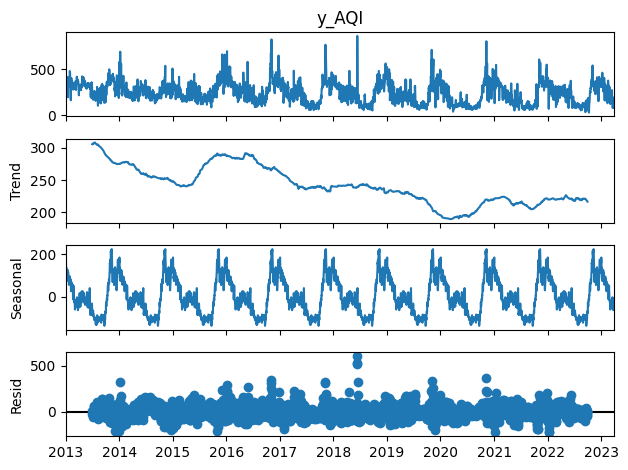

In [6]:
# Assuming df_daily is your DataFrame with a datetime index and the 'y_AQI' column
result = seasonal_decompose(df_daily['y_AQI'], model='additive', period=365)

# Plot the decomposition
result.plot()
plt.show()

In [7]:
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=4, cols=1, subplot_titles=['Original'] + cols)

# Plot Original
fig.add_trace(go.Scatter(x=df_daily.index, y=df_daily['y_AQI'], mode='lines', name='Original'), row=1, col=1)

# Plot Trend, Seasonal, and Residual
for i, col in enumerate(cols, start=2):
    component_data = getattr(result, col.lower()) if col != "Residual" else result.resid  # Accessing components using getattr
    fig.add_trace(go.Scatter(x=df_daily.index, y=component_data, mode='lines', name=col), row=i, col=1)

# Update layout
fig.update_layout(height=800, width=1200, showlegend=True)
fig.show()


### Stationarity Check:
**Objective:** Ensure that the mean and variance of the time series remain constant over time.

Visual Inspection:
Plot the time series data and check for any obvious trends or seasonality.

In [8]:
import plotly.graph_objects as go

# Assuming 'df_daily' is your DataFrame with a datetime index and 'y_AQI' is the target variable
daily_avg = df_daily['y_AQI'].resample('D').mean()

fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg.index, y=daily_avg, mode='lines', name='Daily Avg AQI', line_shape='linear'))
fig.update_layout(title='Time Series Plot (Daily Averages)',
                  xaxis_title='Date',
                  yaxis_title='Average AQI',
                  template='plotly_dark')

fig.show()

We can see that there is some yearly seasonality in the data, but there is no upward or downward treend, it looks flat.

### Statistical Tests:
Use statistical tests like the Augmented Dickey-Fuller test to formally check stationarity.

In [9]:
# Testing For Stationarity
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(df_daily['y_AQI'])
print('ADF Statistic:', test_result[0])
print('p-value:', test_result[1])
print('Critical Values:', test_result[4])

# Ho: The data is non stationary
# H1: The data is stationary
# Interpretation
if test_result[1] <= 0.05:
    print("Strong evidence against the null hypothesis (Ho). Reject the null hypothesis. Data has no unit root and is stationary.")
else:
    print("Weak evidence against null hypothesis. Time series has a unit root, indicating it is non-stationary.")

ADF Statistic: -4.9449309947085185
p-value: 2.8491549626027422e-05
Critical Values: {'1%': -3.432108144995907, '5%': -2.862316851276395, '10%': -2.5671835289365323}
Strong evidence against the null hypothesis (Ho). Reject the null hypothesis. Data has no unit root and is stationary.


The ADF Statistic is significantly lower than the critical values, and the p-value is zero. This suggests that we can reject the null hypothesis of non-stationarity. In other words, the time series appears to be stationary.

Since ADF test confirms stationarity, we can fit the model directly without additional differencing.

But since we definitely see some pattern in the data we can perform differencing.

### Differencing
- Differencing is crucial for ARIMA and SARIMA models as it transforms non-stationary time series data into a stationary form by eliminating trends and seasonality. 
- This step stabilizes the mean, addresses non-constant variance, and ensures stationary residuals, optimizing the models for accurate forecasting.

In [10]:
df_daily['y_AQI_yearly_diff'] = df_daily['y_AQI'].diff(365)  # Assuming daily data and a yearly seasonality

# Drop missing values resulting from differencing
df_daily.dropna(inplace=True)

### Visualize the differenced target variable(y_AQI_yearly_diff)

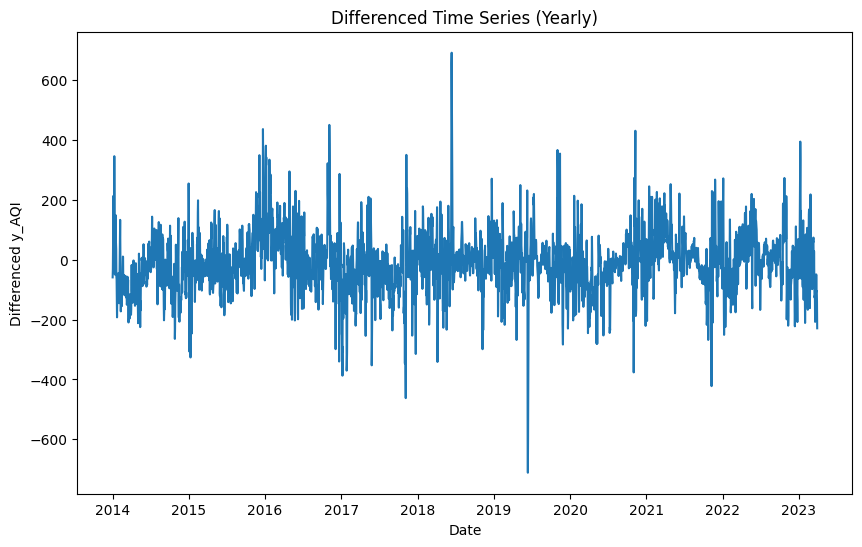

In [11]:
# Plot the differenced time series
plt.figure(figsize=(10, 6))
plt.plot(df_daily['y_AQI_yearly_diff'])
plt.title('Differenced Time Series (Yearly)')
plt.xlabel('Date')
plt.ylabel('Differenced y_AQI')
plt.show()

The differenced data does look stationary, let's compare the original vs. differenced target variable

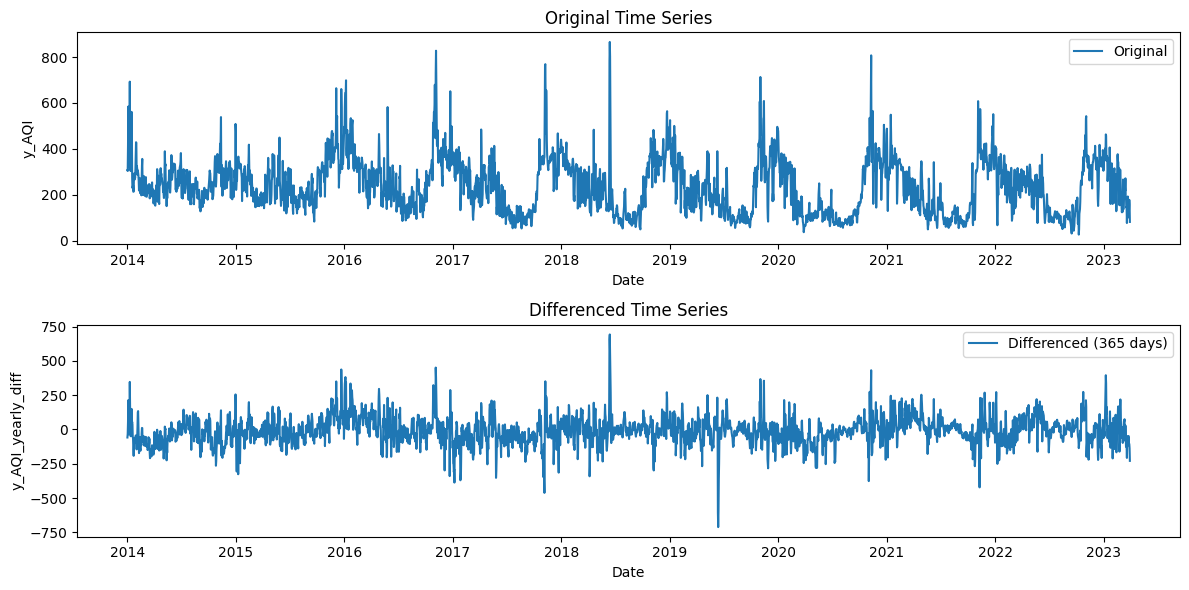

In [12]:
# Plot original and differenced series
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df_daily['y_AQI'], label='Original')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('y_AQI')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df_daily['y_AQI_yearly_diff'], label='Differenced (365 days)')
plt.title('Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('y_AQI_yearly_diff')
plt.legend()

plt.tight_layout()
plt.show()

ADF Test to check for stationarity

In [13]:
# ADF test after differencing
result = adfuller(df_daily['y_AQI_yearly_diff'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')

ADF Statistic: -6.972299373427266
p-value: 8.602650281998605e-10
Critical Values: {'1%': -3.432304111473485, '5%': -2.862403412310526, '10%': -2.56722961145352}


Let's prepare the dataset for training a machine learning model by removing columns that are deemed unnecessary for the modeling task.

**Columns to Remove:**
   - The specified columns include identifiers ('StationId'), the target variable ('y_AQI' - the Air Quality Index we want to predict), and the original columns that have been log transformed.
   
X is a DataFrame containing the selected predictor variables after dropping the unnecessary columns. It includes the features that will be used for training the model.

y is a Series representing the target variable ('y_AQI'). It is the variable we want the model to predict.   

In [14]:
# Removing the columns that we don't need
X_columns = df_daily.drop(['Year', 'y_AQI',
                     'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NOx (ug/m3)', 'NH3 (ug/m3)', 'SO2 (ug/m3)',
                     'CO (ug/m3)', 'Ozone (ug/m3)', 'WS (m/s)', 'SR (W/mt2)',
                     'Volatility_Last_24hr', 'Volatility_Last_7d', 'Volatility_Last_30d'], axis=1).columns.tolist()

# Selecting the features (X) and the target variable (y)
X = df_daily[X_columns]
y = df_daily['y_AQI']     

In [15]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (3376, 29)
Shape of y: (3376,)


### Manual Train - Test Split

The dataset is split into training and testing sets to facilitate model training and evaluation. The training set includes data up to August 2022, while the test set comprises data from September 2022 onwards.

In [16]:
# Splitting the data based on the given date
train = df_daily[df_daily.index < '2022-03-01']
test = df_daily[df_daily.index >= '2022-03-01']

# Removing unnecessary columns from the training and testing sets
X_train = train[X_columns]
y_train = train['y_AQI']

X_test = test[X_columns]
y_test = test['y_AQI']

Scaling is generally not required for ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) models. These models are based on differencing and autoregressive, moving average components, and they operate on the original scale of the data. I have still done the scaling in case I use additional features as exogenous variables in my SARIMAX modeling.

In [17]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train and Test Sets with Train-Test Split Highlighted

In [18]:
import plotly.graph_objects as go

# Assuming you have already defined the train and test DataFrames

# Plotting the training set
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['y_AQI'], mode='lines', name='Train', line=dict(color='blue')))

# Plotting the test set
fig.add_trace(go.Scatter(x=test.index, y=test['y_AQI'], mode='lines', name='Test', line=dict(color='green')))

# Add a red dotted line to separate the train and test sets
fig.add_shape(
    type='line',
    x0=train.index[-1],
    x1=train.index[-1],
    y0=min(min(train['y_AQI']), min(test['y_AQI'])),
    y1=max(max(train['y_AQI']), max(test['y_AQI'])),
    line=dict(color='red', width=2, dash='dot'),
    name='Train-Test Split'
)

# Update layout with a headline
fig.update_layout(
    title='Train and Test Sets with Train-Test Split',
    yaxis_title='y_AQI',
    xaxis_title='Date'
)

# Show the plot
fig.show()


### ACF and PACF Plots for ARIMA Modeling
In time series analysis, Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots are crucial for identifying the appropriate orders of an ARIMA model. Here's how to interpret these plots:

The _partial autocorrelation_ is the autocorrelation after removing the effect of any correlations resulting from terms at shorter lags. We can get this plot using the _partial auto-correlation function_ (`pacf`) from `statsmodels`.

### Identifying Seasonality:
Peaks at regular intervals in the ACF plot suggest seasonality. For example, in hourly data, peaks at lags of 24 may indicate daily seasonality, while peaks at lags of 168 (24 * 7) may indicate weekly seasonality.

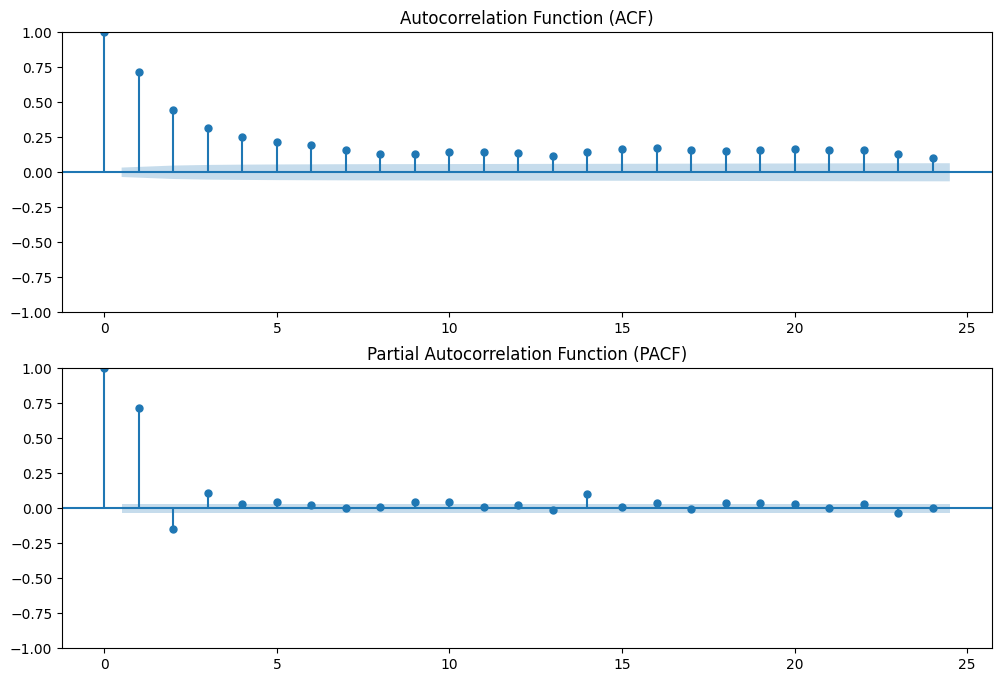

In [ ]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF Plot
plot_acf(df_daily['y_AQI_yearly_diff'].dropna(), lags=24, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF Plot
plot_pacf(df_daily['y_AQI_yearly_diff'].dropna(), lags=24, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

#### Interpretation:
##### Exponential Decay in ACF plot:

* We can see an exponential decay in the ACF plot which implies that the correlation between the time series and its lagged values decreases gradually as the lag increases.
* The absence of a sudden fall or abrupt drop in the ACF plot indicates that there is no distinct, dominant seasonality in the data.
* This pattern suggests that there is a long-range dependence in the time series. In other words, the current observation is correlated with its past observations, and this correlation decreases gradually over time.
* A gradual decrease in autocorrelation without a sudden fall suggests that the time series has a long-term memory, and past observations have an impact on future values.

We can choose p based on the lag where the PACF plot first crosses the upper confidence interval after lag zero, that is 2 in our case, For q let's choose 1, since our data is stationary we can set d = 0, and p = 2
a value $d=1$ is is usually used but since we already applied seasonal differencing, we opt to `d=0` now. 

### ARIMA Modeling:

In [91]:
p, d, q = (2, 0, 1)
arima_model = ARIMA(train['y_AQI_yearly_diff'], order=(p, d, q))
arima_results = arima_model.fit()

# Model Summary
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:      y_AQI_yearly_diff   No. Observations:                 2981
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -16887.817
Date:                Thu, 04 Jan 2024   AIC                          33785.634
Time:                        21:12:51   BIC                          33815.634
Sample:                    01-01-2014   HQIC                         33796.429
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.1826      4.231     -2.879      0.004     -20.475      -3.890
ar.L1          0.4044      0.061      6.646      0.000       0.285       0.524
ar.L2          0.1538      0.049      3.152      0.0

In [ ]:
# Residual Analysis
residuals = arima_results.resid
plt.figure(figsize=(12, 6))

# Plot ACF with more lags and confidence intervals
plt.subplot(1, 2, 1)
plot_acf(residuals, lags=40, zero=False, alpha=0.05)
plt.title('ACF of Residuals with Confidence Intervals')

# Plot residuals
plt.subplot(1, 2, 2)
residuals.plot(title='Residuals')
plt.show()

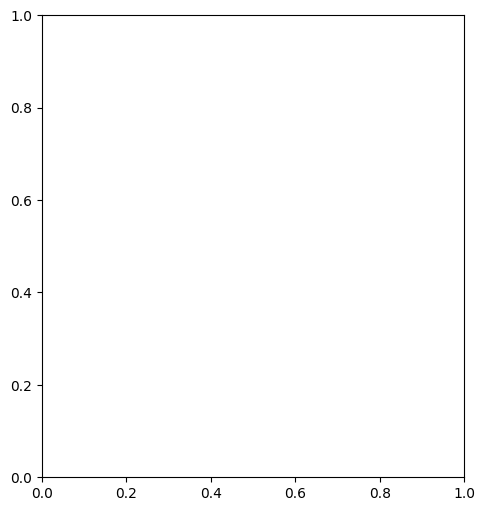

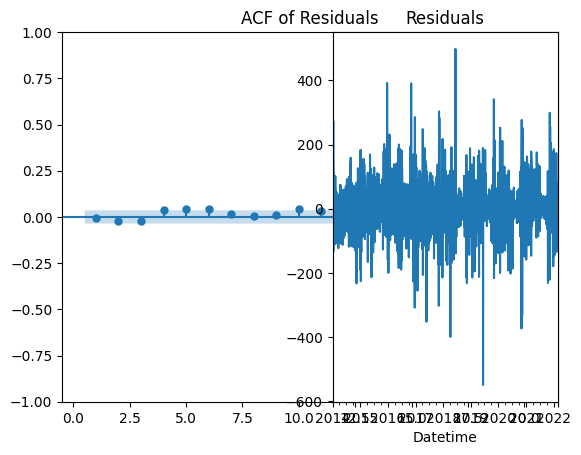

In [92]:
# Residual Analysis
residuals = arima_results.resid
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(residuals, lags=20, zero=False)
plt.title('ACF of Residuals')

plt.subplot(1, 2, 2)
residuals.plot(title='Residuals')
plt.show()

### Forecasting on the Testing Set
The variable forecast_steps is set to the length of the testing set, indicating the number of steps to forecast into the future.

In [94]:
# Forecasting on the testing set
forecast_steps = len(test)  # Forecast the entire testing set
forecast = arima_results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean

### Visualization of ARIMA Model's performance
Let's generates a plot illustrating the performance of the ARIMA model. 

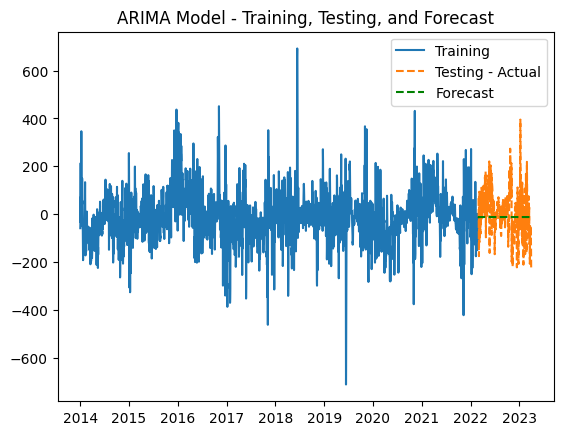

In [ ]:
# Visualization
plt.plot(train['y_AQI_yearly_diff'], label='Training')
plt.plot(test['y_AQI_yearly_diff'], label='Testing - Actual', linestyle='--')
plt.plot(test.index, forecast_values, label='Forecast', linestyle='--', color='green')
plt.legend()
plt.title('ARIMA Model - Training, Testing, and Forecast')
plt.show()

### Model Evaluation:

In [95]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test['y_AQI_yearly_diff'], forecast_values)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test['y_AQI_yearly_diff'], forecast_values)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 72.13791494679897
Mean Squared Error (MSE): 8789.163511086424
Root Mean Squared Error (RMSE): 93.7505387242464


### Percentage Mean Absolute Error (PMAE)

In [97]:
# Calculate PMAE
absolute_percentage_errors = np.abs((X_test_scaled_df['y_AQI_yearly_diff'] - predictions) / X_test_scaled_df['y_AQI_yearly_diff'])
pmae = np.mean(absolute_percentage_errors) * 100

# Print the result
print(f'Percentage Mean Absolute Error (PMAE): {pmae:.2f}%')

Percentage Mean Absolute Error (PMAE): 185.23%


Next I chose SARIMAX for its ability to model clear temporal patterns, incorporate exogenous variables, handle stationary data, capture multi-seasonal patterns, and provide interpretable insights in short to medium-term forecasting.

Converting scaled numpy array back to data frame to input into the model

In [98]:
# Convert scaled arrays back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_columns)

# Ensure the index of X_train_scaled_df matches 'y_AQI_yearly_diff'
X_train_scaled_df.index = X_train.index

# Convert scaled arrays back to DataFrame
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_columns)

# Ensure the index of X_train_scaled_df matches 'y_AQI_yearly_diff'
X_test_scaled_df.index = X_test.index

In [99]:
X_train_scaled_df.head()

,AQI,RH (%),WD (degree),BP (mmHg),AT (degree C),RF (mm),Month,DayOfWeek,MA_Last_7d,MA_Last_30d,...,t_Ozone (ug/m3),t_WS (m/s),t_SR (W/mt2),t_Volatility_Last_24hr,t_Volatility_Last_7d,t_Volatility_Last_30d,t_AQI_lag_24hr,t_AQI_lag_48hr,t_AQI_lag_168hr,y_AQI_yearly_diff
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.109994,1.424788,1.237189,1.163315,-1.465840,-0.194159,-1.555314,-0.500335,0.036023,0.393885,...,-2.157632,-1.200600,0.802610,1.513315,0.040657,0.081925,-0.280277,0.644366,0.191126,-0.450858
2014-01-02,0.569268,0.765644,2.199351,1.167159,-1.800905,-0.194159,-1.555314,-0.000335,0.113398,0.398444,...,-2.064051,-0.864872,0.892028,-0.072127,0.191056,0.088378,0.325224,-0.281150,0.267140,-0.199543
2014-01-03,0.539385,0.362508,0.044165,1.171002,-1.770213,-0.194159,-1.555314,0.499665,0.170588,0.407688,...,-2.080794,-1.388222,0.964120,-1.906616,0.294193,0.088614,0.710034,0.324581,0.465479,0.626608
2014-01-04,1.457220,1.264611,-1.258989,1.174846,-1.625972,-0.194159,-1.555314,0.999665,0.285467,0.433650,...,-3.930170,-1.928728,0.236429,0.769978,0.593786,0.143157,0.688572,0.709538,0.240243,2.182902
2014-01-05,2.933939,1.619059,-1.098301,1.178690,-1.624989,-0.194159,-1.555314,1.499665,0.667537,0.532859,...,-4.590529,-2.305237,0.953213,1.946459,1.593892,0.543939,1.222725,0.688068,0.260169,-0.224150


SARIMAX modeling with exogenous variables code took forever to run, hence I have removed the code.

## Choosing SARIMA Model for Time Series Data

For our hourly time series data with a clear daily seasonality, selecting a Seasonal Autoregressive Integrated Moving Average (SARIMA) model is a prudent choice. SARIMA is well-suited for capturing repeating patterns, evident in your data with peaks occurring every 24 hours. The model's parameters are tailored to handle both non-seasonal and seasonal components, making it ideal for accurate forecasting in the presence of daily seasonality.

The parameters for a SARIMA model are typically denoted as (p, d, q)(P, D, Q)m, where:

* p: Order of the non-seasonal autoregressive component(The number of lag observations included in the model)
* d: Order of non-seasonal differencing(he number of differences needed to make the time series stationary)
* q: Order of the non-seasonal moving average component.
* P: Order of the seasonal autoregressive component.
* D: Order of seasonal differencing.
* Q: Order of the seasonal moving average component.
* m: Seasonal period (in our case, 24 for daily seasonality).

**m = 7 here is taken for weekly seasonality**

In [100]:
# Specify the order and seasonal_order 
order = (1, 0, 1) 
seasonal_order = (1, 0, 1, 7)  # Suspecting weekly seasonality

# Create and fit the SARIMAX model without enforcing stationarity and invertibility
sarimax_model = SARIMAX(X_train_scaled_df['y_AQI_yearly_diff'], order=order, seasonal_order=seasonal_order)
sarimax_results = sarimax_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03139D+00    |proj g|=  7.64871D-02


 This problem is unconstrained.



At iterate    5    f=  1.02844D+00    |proj g|=  5.41996D-03

At iterate   10    f=  1.02836D+00    |proj g|=  1.27191D-03

At iterate   15    f=  1.02767D+00    |proj g|=  3.43727D-02

At iterate   20    f=  1.02573D+00    |proj g|=  1.20587D-03

At iterate   25    f=  1.02571D+00    |proj g|=  1.30864D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     32      1     0     0   5.407D-06   1.026D+00
  F =   1.0257073776222125     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [101]:
print(sarimax_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                 y_AQI_yearly_diff   No. Observations:                 2981
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -3057.634
Date:                           Thu, 04 Jan 2024   AIC                           6125.267
Time:                                   21:14:25   BIC                           6155.267
Sample:                               01-01-2014   HQIC                          6136.062
                                    - 02-28-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5705      0.015     38.641      0.000       0.542       0.599
ma.L1          0.2861      0.017     16.969

These results offer insights into the model's goodness of fit, parameter estimates, and diagnostic tests.

### Forecasting with SARIMA Model

In [102]:
forecast_steps = len(X_test_scaled)
forecast = sarimax_results.get_forecast(steps=forecast_steps)

### Model Evaluation Metrics
After generating predictions with the SARIMAX model, key evaluation metrics have been computed:

**MAE (Mean Absolute Error):** Measures the average absolute difference between actual and predicted values.

**MSE (Mean Squared Error):** Quantifies the average squared difference between actual and predicted values.

**RMSE (Root Mean Squared Error):** Square root of MSE, providing a measure of prediction accuracy.

In [103]:
predictions = forecast.predicted_mean
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 217.39885147726753
Mean Squared Error (MSE): 58055.551751409585
Root Mean Squared Error (RMSE): 240.94719701920084


### Percentage Mean Absolute Error (PMAE)

The Percentage Mean Absolute Error (PMAE) is computed by taking the absolute percentage errors between the observed and predicted values, averaging them, and expressing the result as a percentage. This metric provides insights into the average magnitude of errors relative to the actual values.

In [104]:
# Calculate PMAE
absolute_percentage_errors = np.abs((X_test_scaled_df['y_AQI_yearly_diff'] - predictions) / X_test_scaled_df['y_AQI_yearly_diff'])
pmae = np.mean(absolute_percentage_errors) * 100

# Print the result
print(f'Percentage Mean Absolute Error (PMAE): {pmae:.2f}%')

Percentage Mean Absolute Error (PMAE): 186.61%


### SARIMAX Model Performance Visualization(Actual Vs. Predicted values)

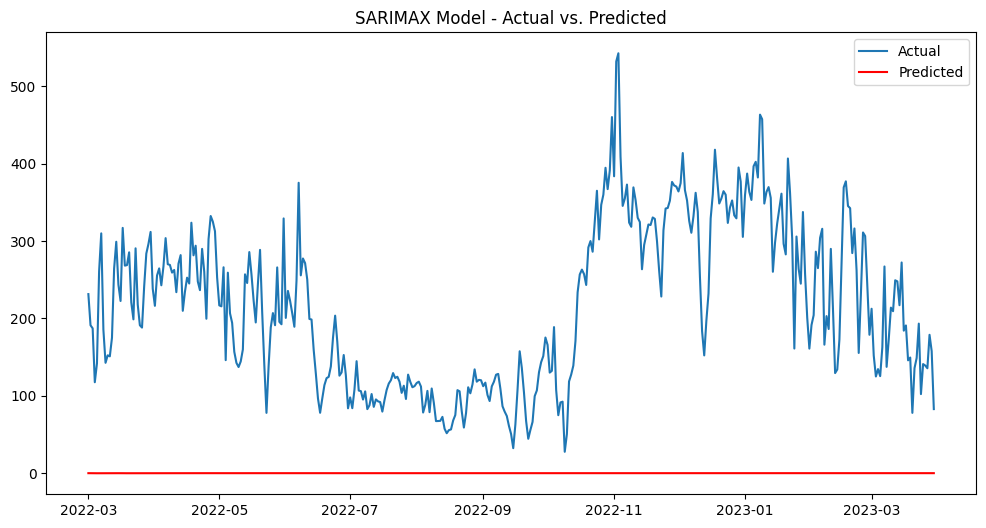

In [105]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.title('SARIMAX Model - Actual vs. Predicted')
plt.legend()
plt.show()

**m = 365 here is taken for yearly seasonality**

In [35]:
# Specify the order and seasonal_order 
order = (1, 0, 1) 
seasonal_order = (1, 0, 1, 365)  # Suspecting yearly seasonality

# Create and fit the SARIMAX model without enforcing stationarity and invertibility
sarimax_model = SARIMAX(X_train_scaled_df['y_AQI_yearly_diff'], order=order, seasonal_order=seasonal_order)
sarimax_results = sarimax_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22222D-01    |proj g|=  4.34919D-01


 This problem is unconstrained.



At iterate    5    f=  8.62939D-01    |proj g|=  1.39342D-01

At iterate   10    f=  8.35164D-01    |proj g|=  2.72779D-02

At iterate   15    f=  8.34404D-01    |proj g|=  2.17634D-03

At iterate   20    f=  8.34399D-01    |proj g|=  4.17160D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   4.172D-05   8.344D-01
  F =  0.83439945657382331     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [37]:
print(sarimax_results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                   y_AQI_yearly_diff   No. Observations:                 2981
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 365)   Log Likelihood               -2487.345
Date:                             Thu, 04 Jan 2024   AIC                           4984.690
Time:                                     10:54:18   BIC                           5014.690
Sample:                                 01-01-2014   HQIC                          4995.484
                                      - 02-28-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6371      0.014     46.501      0.000       0.610       0.664
ma.L1          0.2214      

### Forecasting with SARIMA Model

In [38]:
forecast_steps = len(X_test_scaled)
forecast = sarimax_results.get_forecast(steps=forecast_steps)

### Model Evaluation

In [39]:
predictions = forecast.predicted_mean
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 217.46947172251612
Mean Squared Error (MSE): 58101.540439915145
Root Mean Squared Error (RMSE): 241.0426112535191


### SARIMAX Model Performance Visualization(Actual Vs. Predicted values)

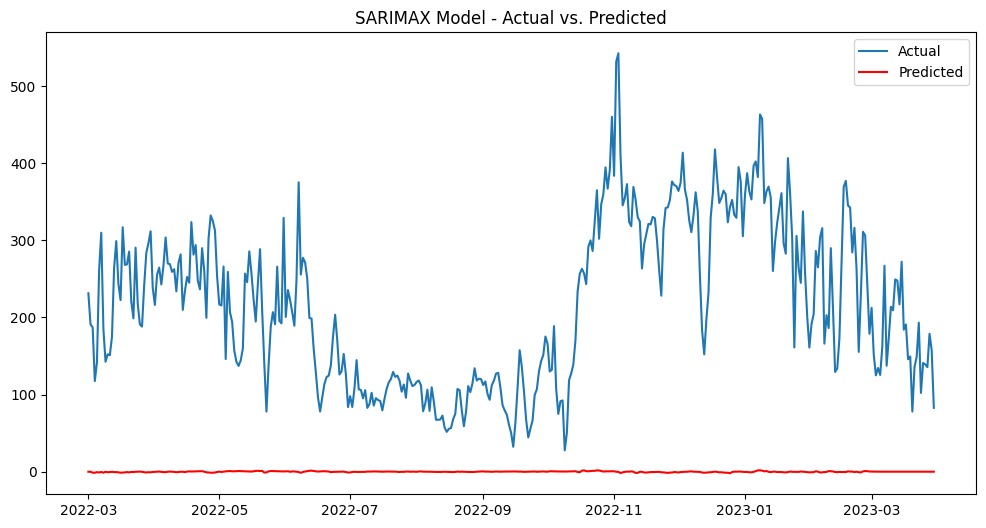

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.title('SARIMAX Model - Actual vs. Predicted')
plt.legend()
plt.show()


## Conclusion:

The ARIMA and SARIMA models, with weekly and yearly seasonality, exhibit high Percentage Mean Absolute Error (PMAE) values (185.23%, 186.61%, and similar). These results suggest that the models are not providing accurate predictions relative to the actual values. The inclusion of seasonality did not significantly improve forecasting accuracy. Further refinement, parameter tuning, and exploration of alternative modeling approaches are recommended to enhance predictive performance.